In [1]:
# ========= 1) Setup =========
# Install required libraries if needed
#!pip install medmnist torch torchvision shap matplotlib

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import shap
import numpy as np
import random
import os
import cv2

import medmnist
from medmnist import INFO

/Users/dmorales/miniconda3/envs/labShap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ========= 2) Dataset Info =========
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
n_classes = len(info['label'])
id2label = {int(k): v for k, v in info['label'].items()}

print(f"Dataset: {info['description']}")
print(f"Task: {info['task']}, Classes: {n_classes}")
print("Classes:", id2label)

Dataset: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Task: multi-class, Classes: 9
Classes: {0: 'adipose', 1: 'background', 2: 'debris', 3: 'lymphocytes', 4: 'mucus', 5: 'smooth muscle', 6: 'normal colon mucosa', 7: 'cancer-associated stroma', 8: 'colorectal adenocarcinoma epithelium'}


/var/folders/cj/gk9lc7jj0cs_ttmx57dq32cw0000gn/T/ipykernel_3528/2993257161.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i].set_title(f"{id2label[int(label)]}")  # ✅ cast label to int
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32549018..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44313723..0.90588236].


Train size: 89996  Test size: 7180


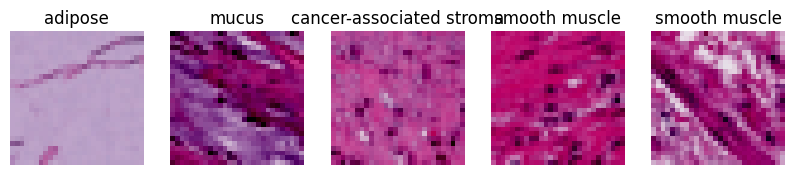

In [3]:
# ========= 3) Load dataset =========
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=transform, download=download)
test_dataset  = DataClass(split='test', transform=transform, download=download)

print("Train size:", len(train_dataset), " Test size:", len(test_dataset))

# Show 5 sample images
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img, label = train_dataset[i]
    img = img.numpy()
    axs[i].imshow(np.transpose(img, (1, 2, 0)).squeeze(), cmap="gray")
    axs[i].set_title(f"{id2label[int(label)]}")  # ✅ cast label to int
    axs[i].axis("off")
plt.show()

In [4]:
# ========= 4) Define Simple CNN Model (already provided) =========
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*14*14, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x

model = SimpleCNN(info['n_channels'], n_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model class defined and ready.")

Model class defined and ready.


In [5]:
# ========= 5) Load Pretrained Model =========
MODEL_PATH = "pathmnist_simplecnn.pth"

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print("Pretrained model loaded successfully!")

Pretrained model loaded successfully!


/var/folders/cj/gk9lc7jj0cs_ttmx57dq32cw0000gn/T/ipykernel_3528/3961524630.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Etiqueta real: {id2label[int(sample_label)]}")


Predicción: normal colon mucosa (0.71)
Etiqueta real: colorectal adenocarcinoma epithelium


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..0.9137255].


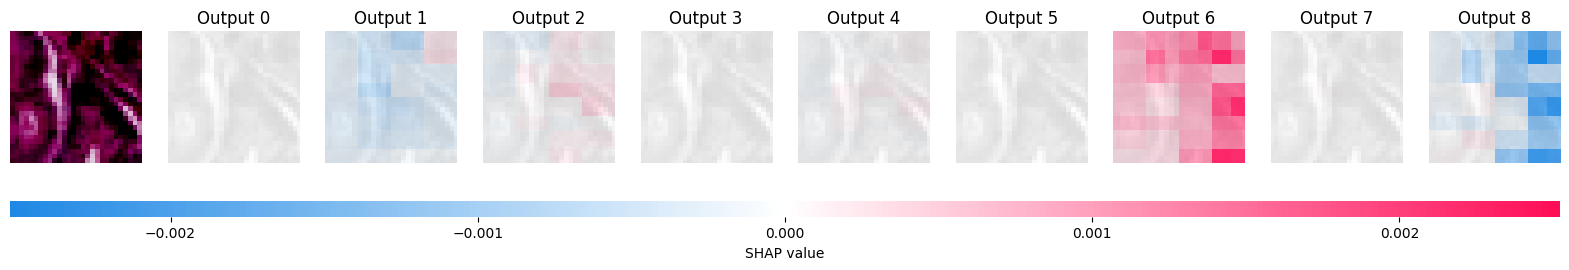

In [6]:
# Paso 1: Helper para SHAP
def model_forward(x):
    x_tensor = torch.tensor(np.transpose(x, (0, 3, 1, 2)), dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().numpy()

# Paso 2: Selecciona imagen y predice
idx = 0  # puedes cambiar por random.randint(0, len(test_dataset)-1)
sample_img, sample_label = test_dataset[idx]
img_np = np.transpose(sample_img.numpy(), (1, 2, 0))  # (H, W, C)
probs = model_forward(img_np[None, ...])[0]
pred_class = np.argmax(probs)
print(f"Predicción: {id2label[pred_class]} ({probs[pred_class]:.2f})")
print(f"Etiqueta real: {id2label[int(sample_label)]}")

# Paso 3: Prepara imagen para SHAP (ya hecho arriba)

# Paso 4: Explainer de SHAP
masker = shap.maskers.Image("blur(28,28)", img_np.shape)
explainer = shap.Explainer(model_forward, masker)
shap_values = explainer(img_np[None, ...])

# Paso 5: Visualización con SHAP
shap.image_plot(shap_values, img_np[None, ...])

/var/folders/cj/gk9lc7jj0cs_ttmx57dq32cw0000gn/T/ipykernel_3528/748567193.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels.append(id2label[int(sample_label)])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26274508..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47450978..0.73333335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47450978..0.6784314].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4980392..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0.

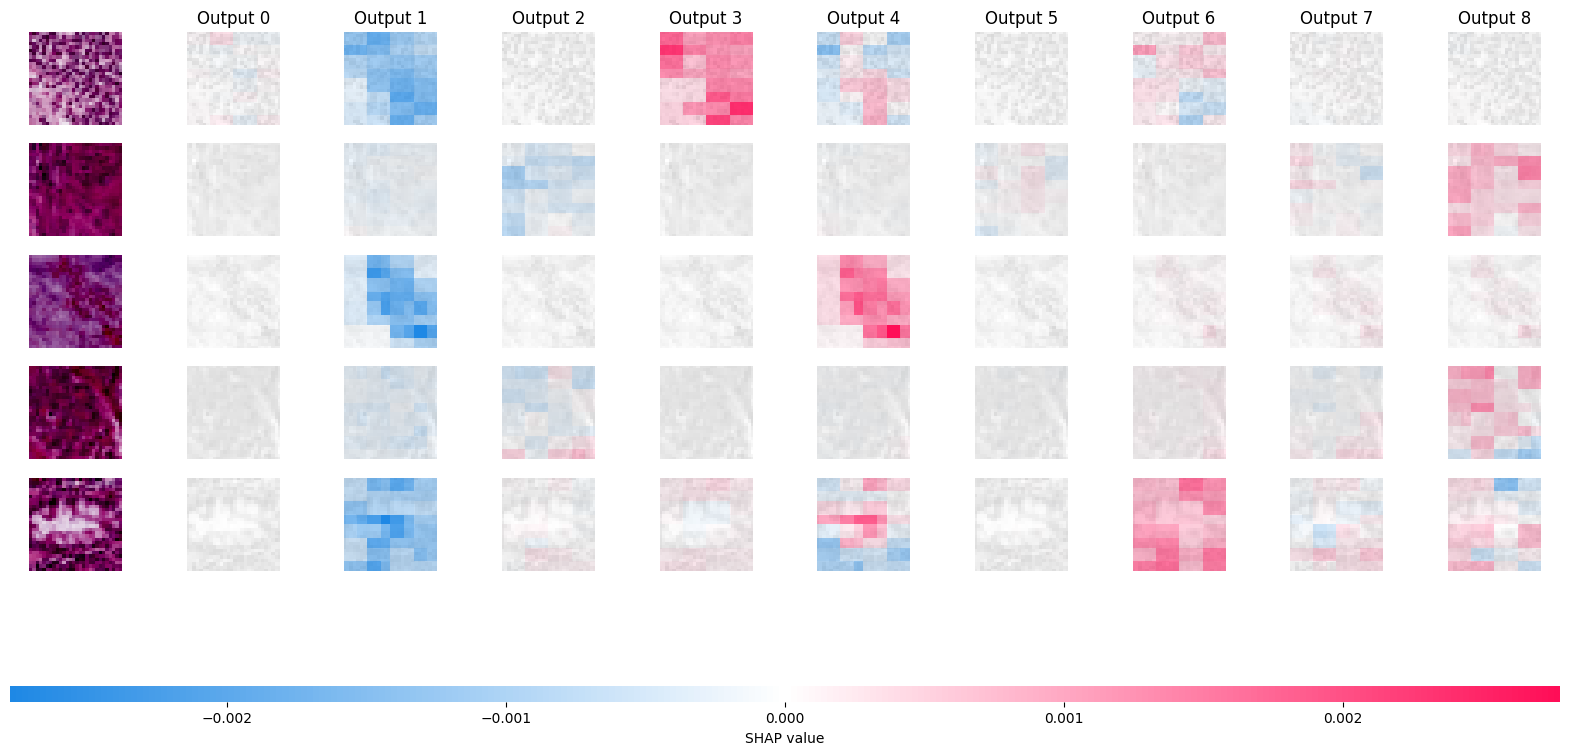

In [12]:
# Selecciona 5 índices aleatorios
random_idxs = random.sample(range(len(test_dataset)), 5)
imgs = []
labels = []

for idx in random_idxs:
    sample_img, sample_label = test_dataset[idx]
    img_np = np.transpose(sample_img.numpy(), (1, 2, 0))
    imgs.append(img_np)
    labels.append(id2label[int(sample_label)])

imgs_np = np.stack(imgs)  # (5, H, W, C)

masker = shap.maskers.Image("blur(28,28)", imgs_np[0].shape)
explainer = shap.Explainer(model_forward, masker)
shap_values = explainer(imgs_np)

# Visualiza con SHAP
shap.image_plot(shap_values, imgs_np)

# ========= 8) Reflection =========
### ¿Por qué predijo esa clase?
El modelo se apoya en **texturas y tonos característicos**: en *adipose* resalta zonas pálidas y bloques de baja frecuencia; en *background* la uniformidad morada; en *normal colon mucosa* patrones granulares regulares. Los mapas **SHAP** (*rojo = empuja a la clase, azul = la aleja*) marcan justamente esas regiones.

### ¿Los heatmaps miran zonas significativas?
En general **sí**: se enfocan en estructuras tisulares (límites celulares, fibras, lóbulos grasos) y no en márgenes en blanco. Donde falla (p. ej., *smooth muscle → lymphocytes*), el SHAP se concentra en gránulos/patches que el modelo confunde con cúmulos de linfocitos, lo cual es plausible pero no correcto.

### Diferencias entre aciertos y errores
- **Aciertos:** contribuciones coherentes y localizadas, con patrones anatómicos claros; probabilidades altas (p. ej., **1.00** en *background*, **0.83** en *normal colon*).
- **Errores:** contribuciones dispersas o mal ubicadas y, a veces, **sobreconfianza** (**0.99** para un *smooth muscle* mal clasificado como *lymphocytes*) o atención a regiones no diagnósticas; en el caso **cáncer → normal (0.63)**, el modelo “ignora” glándulas malignas y se ancla en áreas que parecen normales.

### ¿Cómo ayuda la interpretabilidad a mejorar el modelo?
- **Curación de datos:** detectar pistas espurias (fondos, bordes, artefactos) y ampliar esas clases con *hard negatives*.
- **Preprocesamiento:** recortar/máscar fondo, usar **deconvolución H&E** por canal y **normalización por slide**.
- **Arquitectura/entrenamiento:** entrada mayor (>28×28), más capas/regularización, reponderación por clase y *augmentations* dirigidas a texturas finas.
- **Calibración y evaluación:** calibrar (Platt/Temperature Scaling) para reducir sobreconfianza y revisar *tiles* mal clasificados guiándose por SHAP para diseñar nuevos *augmentations* o reglas de muestreo.
